# Financial Fraud Detection: Machine Learning with Graph Features

In this notebook, we demonstrate how to combine traditional tabular data with **Graph Features** to train a machine learning model for fraud detection. In [loader.ipynb](loader.ipynb), we constructed a Neo4j graph database from the IEEE-CIS Fraud Detection dataset. Here, we will use Neo4j as a feature store to extract relevant data necessary to train our model, as well as to compute additional graph connected features.

> We are not trying to create a state-of-the-art fraud detection model here, or one which would win any competitions. Instead, our goal is to illustrate how graph features can be integrated into a machine learning workflow to potentially enhance model performance. Think of this as a **Graph-Enhanced Baseline Model**, rather than a production-ready solution - we only use a subset of features and a simple model for clarity, missing out on advanced feature engineering, hyperparameter tuning, and model selection.

The following is the workflow we will follow for the model training and evaluation:

- **Feature Engineering (in Neo4j):** We use the **Graph Data Science (GDS)** library to calculate centrality and community metrics directly in the database.
- **Data Extraction:** We query the graph to create a dataset that includes both transaction properties (Amount, Time) and graph features (PageRank, Community Size).
- **Model Training:** We train an **XGBoost** classifier on this graph-enhanced dataset.
- **Evaluation:** We measure performance using ROC-AUC and Precision-Recall curves.

This approach enables the model to learn from the network signals in the graph (e.g., "Is this user part of a fraud ring?"), not just individual columnar attributes typical of tabular data.

In [1]:
import os
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from neo4j import GraphDatabase
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import average_precision_score, roc_auc_score, confusion_matrix

NEO4J_URI = os.getenv("NEO4J_URI")
NEO4J_USER = os.getenv("NEO4J_USER")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD")
NEO4J_TRAIN_DB = os.getenv("NEO4J_TRAIN_DATABASE")
NEO4J_TEST_DB = os.getenv("NEO4J_TEST_DATABASE")

## Graph Pipeline & GDS Setup

We define a `Neo4jGraphPipeline` class to handle interactions with the Neo4j Graph Data Science (GDS) library. This helper manages:
*   **Graph Projection:** Loading a subgraph into memory for analysis.
*   **Feature Engineering:** Running algorithms like **PageRank**, **Degree Centrality**, and **WCC (Weakly Connected Components)**.
*   **Cleanup:** Dropping projections to free up memory.

In [2]:
class Neo4jGraphPipeline:
    def __init__(self, uri, user, password, database):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))
        self.database = database

    def close(self):
        self.driver.close()

    def run_query(self, query, params=None):
        with self.driver.session(database=self.database) as session:
            result = session.run(query, params or {})
            return [record.data() for record in result]

    def run_gds_algorithm(self, query):
        """Run a GDS query that doesn't return data (e.g., writing back to graph)"""
        with self.driver.session(database=self.database) as session:
            session.run(query)
            
    def project_graph(self, graph_name):
        """
        Projects a graph into memory for GDS analysis.
        We project ALL nodes and relationships to capture the full network topology.
        """
        print(f"Projecting graph '{graph_name}' in {self.database}...")
        
        # Check if exists and drop
        exists = self.run_query(f"CALL gds.graph.exists('{graph_name}') YIELD exists RETURN exists")[0]['exists']
        if exists:
            self.run_gds_algorithm(f"CALL gds.graph.drop('{graph_name}')")

        # Project new graph (Native projection for all nodes/rels)
        # Using '*' allows us to capture connectivity between Transactions and Identity nodes (Cards, IPs, etc.)
        query = f"""
        CALL gds.graph.project(
            '{graph_name}',
            '*',
            '*'
        )
        """
        self.run_gds_algorithm(query)
        print(f"Graph '{graph_name}' projected.")

    def run_feature_engineering(self, graph_name):
        """
        Runs PageRank, Degree Centrality, and WCC, writing results back to Transaction nodes.
        """
        print(f"Running Feature Engineering on {self.database}...")
        
        # 1. PageRank: Measures influence/importance of nodes in the network
        print(" - Running PageRank...")
        self.run_gds_algorithm(f"""
        CALL gds.pageRank.write('{graph_name}', {{
            writeProperty: 'pageRank',
            dampingFactor: 0.85,
            maxIterations: 20
        }})
        """)
        
        # 2. Degree Centrality: Measures volume of connections (e.g. shared devices)
        print(" - Running Degree Centrality...")
        self.run_gds_algorithm(f"""
        CALL gds.degree.write('{graph_name}', {{
            writeProperty: 'degree'
        }})
        """)
        
        # Weakly Connected Components (WCC): Identifies disconnected communities
        print(" - Running WCC (Community Detection)...")
        self.run_gds_algorithm(f"""
        CALL gds.wcc.write('{graph_name}', {{
            writeProperty: 'communityId'
        }})
        """)
        
        # Calculate Community Size
        # We perform an aggregation to calculate the size of the community each node belongs to
        print(" - Calculating Community Sizes...")
        self.run_gds_algorithm("""
        MATCH (n)
        WITH n.communityId AS cId, count(*) AS cSize
        MATCH (n) WHERE n.communityId = cId
        SET n.communitySize = cSize
        """)
        
        print("Feature engineering complete.")

    def drop_graph(self, graph_name):
        self.run_gds_algorithm(f"CALL gds.graph.drop('{graph_name}')")

## Running Graph Data Science Algorithms

Here, we execute the feature engineering pipeline on both the **Train** and **Test** databases.

We calculate three key graph features for every node:
1.  **PageRank:** Measures the relative importance of a node (e.g., a device used by many high-value cards).
2.  **Degree Centrality:** Counts the number of direct connections (e.g., how many cards has this device used?).
3.  **Community Size:** Identifies how large the connected group is (e.g., is this transaction part of a huge cluster or isolated?).

In [3]:
# Feature Engineering on TRAIN Database
train_pipeline = Neo4jGraphPipeline(NEO4J_URI, NEO4J_USER, NEO4J_PASSWORD, NEO4J_TRAIN_DB)
try:
    train_pipeline.project_graph('fraud-train')
    train_pipeline.run_feature_engineering('fraud-train')
    train_pipeline.drop_graph('fraud-train') # Cleanup memory
finally:
    train_pipeline.close()

# Feature Engineering on TEST Database
test_pipeline = Neo4jGraphPipeline(NEO4J_URI, NEO4J_USER, NEO4J_PASSWORD, NEO4J_TEST_DB)
try:
    test_pipeline.project_graph('fraud-test')
    test_pipeline.run_feature_engineering('fraud-test')
    test_pipeline.drop_graph('fraud-test')
finally:
    test_pipeline.close()

Projecting graph 'fraud-train' in ieee-cis-fraud-train...
Graph 'fraud-train' projected.
Running Feature Engineering on ieee-cis-fraud-train...
 - Running PageRank...
 - Running Degree Centrality...
 - Running WCC (Community Detection)...
 - Calculating Community Sizes...


Received notification from DBMS server: <GqlStatusObject gql_status='01N00', status_description='warn: feature deprecated. `schema` returned by the procedure `gds.graph.drop` is deprecated.', position=<SummaryInputPosition line=1, column=1, offset=0>, raw_classification='DEPRECATION', classification=<NotificationClassification.DEPRECATION: 'DEPRECATION'>, raw_severity='WARNING', severity=<NotificationSeverity.WARNING: 'WARNING'>, diagnostic_record={'_classification': 'DEPRECATION', '_severity': 'WARNING', '_position': {'offset': 0, 'line': 1, 'column': 1}, 'OPERATION': '', 'OPERATION_CODE': '0', 'CURRENT_SCHEMA': '/'}> for query: "CALL gds.graph.drop('fraud-train')"


Feature engineering complete.
Projecting graph 'fraud-test' in ieee-cis-fraud-test...
Graph 'fraud-test' projected.
Running Feature Engineering on ieee-cis-fraud-test...
 - Running PageRank...
 - Running Degree Centrality...
 - Running WCC (Community Detection)...
 - Calculating Community Sizes...


Received notification from DBMS server: <GqlStatusObject gql_status='01N00', status_description='warn: feature deprecated. `schema` returned by the procedure `gds.graph.drop` is deprecated.', position=<SummaryInputPosition line=1, column=1, offset=0>, raw_classification='DEPRECATION', classification=<NotificationClassification.DEPRECATION: 'DEPRECATION'>, raw_severity='WARNING', severity=<NotificationSeverity.WARNING: 'WARNING'>, diagnostic_record={'_classification': 'DEPRECATION', '_severity': 'WARNING', '_position': {'offset': 0, 'line': 1, 'column': 1}, 'OPERATION': '', 'OPERATION_CODE': '0', 'CURRENT_SCHEMA': '/'}> for query: "CALL gds.graph.drop('fraud-test')"


Feature engineering complete.


## Creating the Dataset (Graph + Tabular)

Now that the graph features (PageRank, Degree, Community Size) are written back to the `Transaction` nodes in Neo4j, we verify and extract them along with the original transaction data.

We use Cypher's `OPTIONAL MATCH` to retrieve related entities (Cards, Addresses, Emails) and their properties, flattening the graph structure into a tabular format suitable for XGBoost.

In [4]:
def extract_data(pipeline, is_train=True):
    # Conditionally include the label for the training set
    label_query = "t.isFraud AS label," if is_train else ""
    
    # We use OPTIONAL MATCH because not every transaction has every relationship 
    # (e.g., some might lack an email or address).
    query = f"""
    MATCH (t:Transaction)
    
    // Traverse to related Hub Nodes to get features
    OPTIONAL MATCH (t)-[:USED_CARD]->(c:Card)
    OPTIONAL MATCH (t)-[:BILLED_TO]->(a:Address)
    OPTIONAL MATCH (t)-[:PURCHASER_EMAIL]->(pe:Email)
    OPTIONAL MATCH (t)-[:RECIPIENT_EMAIL]->(re:Email)
    OPTIONAL MATCH (t)-[:ON_DEVICE]->(d:Device)
    
    RETURN 
        t.id AS TransactionID,
        t.timestamp AS TransactionDT,
        t.amt AS TransactionAmt,
        t.product AS ProductCD,
        t.M1 AS M1,
        t.M2 AS M2,
        t.M3 AS M3,
        t.M4 AS M4,
        t.M5 AS M5,
        t.M6 AS M6,
        t.M7 AS M7,
        t.M8 AS M8,
        t.M9 AS M9,
        
        // Card Features (Mapped from Card Node)
        c.card1 AS card1,
        c.card2 AS card2,
        c.card3 AS card3,
        c.network AS card4,   
        c.card5 AS card5,
        c.type AS card6,      
        
        // Address Features (Mapped from Address Node)
        a.zip AS addr1,       
        a.country AS addr2,   
        
        // Email Features
        pe.domain AS P_emaildomain,
        re.domain AS R_emaildomain,
        
        // Device Features (Mapped from Device Node)
        d.type AS DeviceType,
        d.model AS DeviceInfo,
        d.browser AS id_31,
        d.os AS id_30,
        d.resolution AS id_33,
        
        
        // Graph Features (Written to Transaction node in Step 3)
        t.pageRank AS g_pageRank,
        t.degree AS g_degree,
        t.communitySize AS g_communitySize,
        
        {label_query}
        
        // Additional Distances if needed
        t.dist1 AS dist1,
        t.dist2 AS dist2
        
    ORDER BY t.timestamp ASC
    """
    return pd.DataFrame(pipeline.run_query(query))

# Extract Train Data
print("Extracting Training Data...")
train_pipeline = Neo4jGraphPipeline(NEO4J_URI, NEO4J_USER, NEO4J_PASSWORD, NEO4J_TRAIN_DB)
df_train = extract_data(train_pipeline, is_train=True)
train_pipeline.close()

# Extract Test Data
print("Extracting Test Data...")
test_pipeline = Neo4jGraphPipeline(NEO4J_URI, NEO4J_USER, NEO4J_PASSWORD, NEO4J_TEST_DB)
df_test = extract_data(test_pipeline, is_train=False)
test_pipeline.close()

print(f"Train Shape: {df_train.shape}")
print(f"Test Shape:  {df_test.shape}")

# Preview to verify columns
df_train.head()

Extracting Training Data...
Extracting Test Data...


Received notification from DBMS server: <GqlStatusObject gql_status='01N52', status_description='warn: property key does not exist. The property `browser` does not exist in database `ieee-cis-fraud-test`. Verify that the spelling is correct.', position=<SummaryInputPosition line=45, column=11, offset=1217>, raw_classification='UNRECOGNIZED', classification=<NotificationClassification.UNRECOGNIZED: 'UNRECOGNIZED'>, raw_severity='WARNING', severity=<NotificationSeverity.WARNING: 'WARNING'>, diagnostic_record={'_classification': 'UNRECOGNIZED', '_severity': 'WARNING', '_position': {'offset': 1217, 'line': 45, 'column': 11}, 'OPERATION': '', 'OPERATION_CODE': '0', 'CURRENT_SCHEMA': '/'}> for query: '\n    MATCH (t:Transaction)\n\n    // Traverse to related Hub Nodes to get features\n    OPTIONAL MATCH (t)-[:USED_CARD]->(c:Card)\n    OPTIONAL MATCH (t)-[:BILLED_TO]->(a:Address)\n    OPTIONAL MATCH (t)-[:PURCHASER_EMAIL]->(pe:Email)\n    OPTIONAL MATCH (t)-[:RECIPIENT_EMAIL]->(re:Email)\n   

Train Shape: (590540, 34)
Test Shape:  (506691, 33)


,TransactionID,TransactionDT,TransactionAmt,ProductCD,M1,M2,M3,M4,M5,M6,...,DeviceInfo,id_31,id_30,id_33,g_pageRank,g_degree,g_communitySize,label,dist1,dist2
0,2987000,86400,68.5,W,T,T,T,M2,F,T,...,NaN,NaN,NaN,NaN,0.15,2.0,698417,0,19.0,NaN
1,2987001,86401,29.0,W,NaN,NaN,NaN,M0,T,T,...,NaN,NaN,NaN,NaN,0.15,3.0,698417,0,NaN,NaN
2,2987002,86469,59.0,W,T,T,T,M0,F,F,...,NaN,NaN,NaN,NaN,0.15,3.0,698417,0,287.0,NaN
3,2987003,86499,50.0,W,NaN,NaN,NaN,M0,T,F,...,NaN,NaN,NaN,NaN,0.15,3.0,698417,0,NaN,NaN
4,2987004,86506,50.0,H,NaN,NaN,NaN,NaN,NaN,NaN,...,SAMSUNG SM-G892A Build/NRD90M,samsung browser 6.2,Android 7.0,2220x1080,0.15,4.0,698417,0,NaN,NaN


## Preprocessing

Standard machine learning preprocessing steps:
*   **Categorical Encoding:** We use `OrdinalEncoder` for categorical fields like Product CD and Card Type.
*   **Train/Validation Split:** We use a time-based split (first 80% for training) to mimic a real-world production scenario where we predict future fraud based on past data.

In [5]:
# Identify categorical columns
cat_cols = [
    'ProductCD',
    'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
    'id_30', 'id_31', 'id_33', 'DeviceType', 'DeviceInfo',
    'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
    'P_emaildomain', 'R_emaildomain'
]

# Preprocessing: Fill NaNs AND cast to string
# This prevents the "float < str" error by making everything a string
for col in cat_cols:
    # Check if column exists to avoid key errors
    if col in df_train.columns:
        df_train[col] = df_train[col].fillna('unknown').astype(str)
    
    if col in df_test.columns:
        df_test[col] = df_test[col].fillna('unknown').astype(str)

# Encode
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Fit/Transform
# Ensure we only pass the columns that actually exist in the dataframe
valid_cols = [c for c in cat_cols if c in df_train.columns]

df_train[valid_cols] = encoder.fit_transform(df_train[valid_cols])
df_test[valid_cols] = encoder.transform(df_test[valid_cols])

# Features and Target
X = df_train.drop(columns=['label', 'TransactionID'])
y = df_train['label']

# Split
split_idx = int(len(X) * 0.8)
X_train, X_val = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_val = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Training on {len(X_train)} samples, validating on {len(X_val)} samples.")

Training on 472432 samples, validating on 118108 samples.


## Model Training (XGBoost)

We train an **XGBClassifier** on the processed data.

**Key Hyperparameters:**
*   `scale_pos_weight`: Addresses the heavy class imbalance (fraud is rare).
*   `max_depth` & `learning_rate`: Tuned to capture complex non-linear patterns without overfitting.
*   `eval_metric='aucpr'`: We optimize for Area Under the Precision-Recall Curve, which is better for imbalanced datasets than accuracy.

In [6]:
# Check how many features we actually have
print(f"Training with {X_train.shape[1]} features.")

model = xgb.XGBClassifier(
    # More trees, slower learning
    n_estimators=3000,          # High number of trees
    learning_rate=0.01,         # Forces more detailed learning
    
    # Tree Complexity
    max_depth=15,               # Deep trees for complex fraud patterns
    min_child_weight=5,         # Prevents learning very specific noise (leafs with few samples)
    gamma=0.2,                  # Minimum loss reduction required to make a further partition
    
    # Randomness (Stochastic Gradient Boosting) - Critical for generalization
    subsample=0.7,              # Use only 70% of rows per tree
    colsample_bytree=0.7,       # Use only 70% of features per tree
    
    # Class Imbalance
    scale_pos_weight=20,        # Keeps high penalty for missing fraud
    
    # Speed & Metric
    tree_method='hist',         
    eval_metric='aucpr',
    early_stopping_rounds=200,  # Give it more patience before stopping
    random_state=42
)

print("Starting training...")
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=100  # Log every 100 trees
)

print(f"Best Iteration: {model.best_iteration}")
print(f"Best Validation AUC-PR: {model.best_score}")

Training with 32 features.
Starting training...
[0]	validation_0-aucpr:0.46553	validation_1-aucpr:0.17848
[100]	validation_0-aucpr:0.80339	validation_1-aucpr:0.27956
[200]	validation_0-aucpr:0.86685	validation_1-aucpr:0.29565
[300]	validation_0-aucpr:0.91029	validation_1-aucpr:0.30985
[400]	validation_0-aucpr:0.94065	validation_1-aucpr:0.31735
[500]	validation_0-aucpr:0.95922	validation_1-aucpr:0.32240
[600]	validation_0-aucpr:0.96912	validation_1-aucpr:0.32578
[700]	validation_0-aucpr:0.97693	validation_1-aucpr:0.32666
[800]	validation_0-aucpr:0.98247	validation_1-aucpr:0.32847
[900]	validation_0-aucpr:0.98671	validation_1-aucpr:0.32965
[1000]	validation_0-aucpr:0.98971	validation_1-aucpr:0.33088
[1100]	validation_0-aucpr:0.99183	validation_1-aucpr:0.33214
[1200]	validation_0-aucpr:0.99356	validation_1-aucpr:0.33390
[1300]	validation_0-aucpr:0.99485	validation_1-aucpr:0.33534
[1400]	validation_0-aucpr:0.99584	validation_1-aucpr:0.33684
[1500]	validation_0-aucpr:0.99651	validation_1-au

## Model Evaluation

We evaluate the model's performance on the hold-out validation set.

*   **ROC Curve:** Shows the trade-off between True Positive Rate and False Positive Rate.
*   **Precision-Recall Curve:** Critical for fraud detection. It shows how many of our flagged transactions were actual fraud (Precision) vs. how much total fraud we caught (Recall).

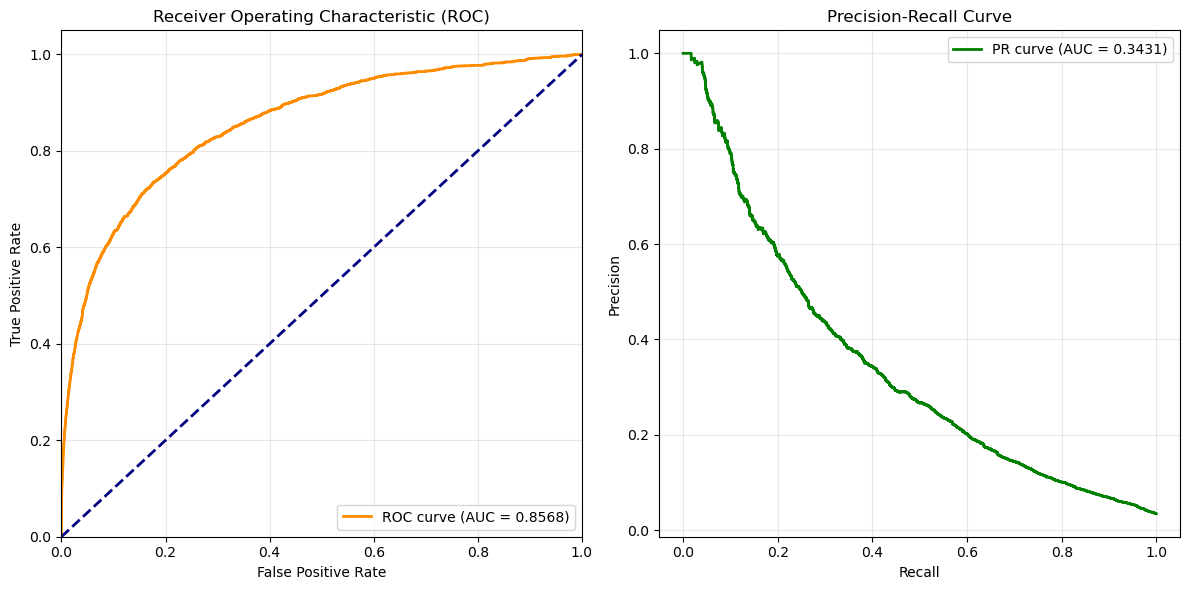

In [7]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Get predictions for the validation set
val_probs = model.predict_proba(X_val)[:, 1]

fpr, tpr, _ = roc_curve(y_val, val_probs)
roc_auc = auc(fpr, tpr)

precision, recall, _ = precision_recall_curve(y_val, val_probs)
pr_auc = average_precision_score(y_val, val_probs)

plt.figure(figsize=(12, 6))

# Plot ROC
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# Plot Precision-Recall
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Feature Importance

Which features drove the model's decisions?

We visualize the top features. In a successful graph ML project, we often see **Graph Features** (like `g_degree` or `g_communitySize`) ranking highly alongside traditional signals like Transaction Amount. This confirms that the network structure provides valuable predictive signal.

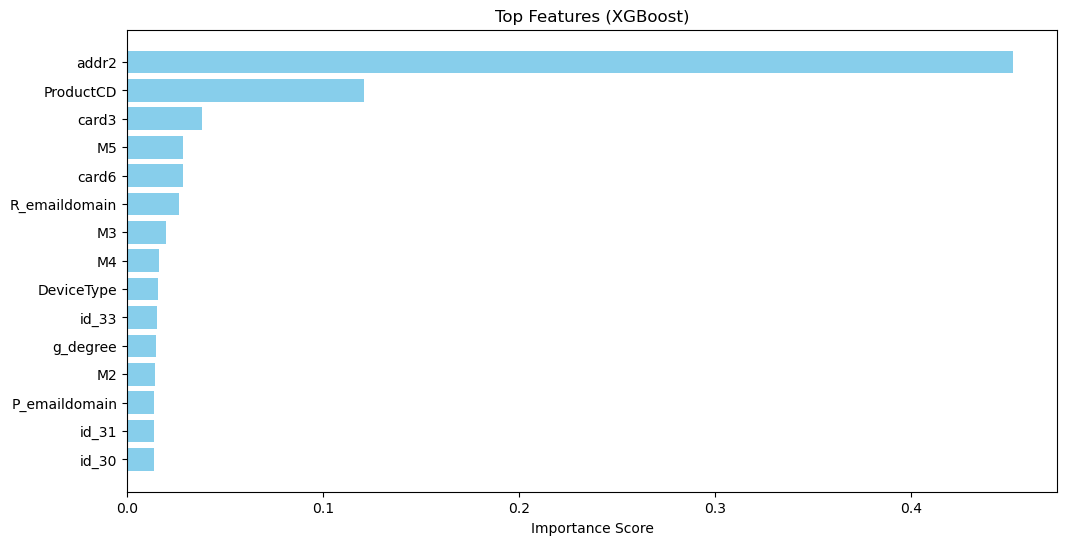

In [8]:
import matplotlib.pyplot as plt

importance = model.feature_importances_
feature_names = X.columns

feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(12, 6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.title('Top Features (XGBoost)')
plt.gca().invert_yaxis() # Highest importance at the top
plt.show()

## Inference on Test Set

Finally, we apply our trained model to the separate `Test` dataset.

Note that the Test data was processed with the *same* graph feature engineering steps (isolated from training data to prevent leakage).

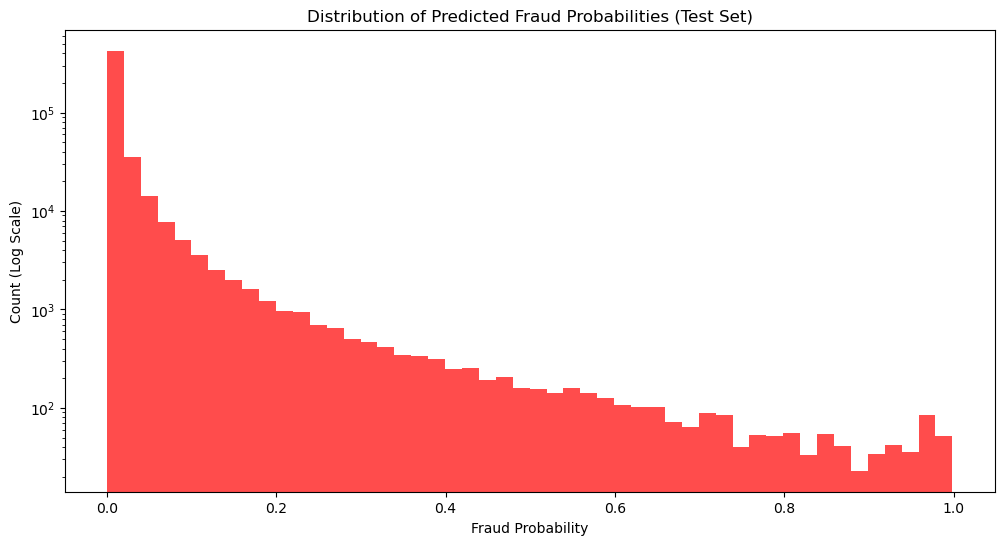

,TransactionID,isFraud
0,3663549,0.003235
1,3663550,0.004728
2,3663551,0.007270
3,3663552,0.002103
4,3663553,0.000411


In [9]:
# Prepare Test features
X_test = df_test.drop(columns=['TransactionID'])

# Predict
test_probs = model.predict_proba(X_test)[:, 1]

# Create Result DataFrame
submission = pd.DataFrame({
    'TransactionID': df_test['TransactionID'],
    'isFraud': test_probs
})

# Display distribution of fraud predictions
plt.figure(figsize=(12, 6))
plt.hist(submission['isFraud'], bins=50, color='red', alpha=0.7)
plt.title('Distribution of Predicted Fraud Probabilities (Test Set)')
plt.yscale('log')
plt.xlabel('Fraud Probability')
plt.ylabel('Count (Log Scale)')
plt.show()

# Show sample
submission.head()

In [10]:
# Save submission file to CSV
submission.to_csv('fraud_submission.csv', index=False)